In [30]:
import funzioni02 as f2
import numpy as np
import datetime
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2022-03-20 20:57:21,086: Credentials are already in use. The existing account in the session will be replaced.


# Grafico fidelity vs. steps

### Creo il primo ciclo per realizzare tutti i circuiti da eseguire (a parte la calibrazione)

In [31]:
### definisco i parametri fissati per la realizzazione del grafico
shots=32000
reps=8  # al massimo 10
precision=40
tempo=np.pi
backend_aus=backend_sim_jakarta
check=["4copy_check", [0,2,4,6]]
evo_type="column_evolution" # "column_evolution" or "complete_evolution" or "trotter_steps"
measure_mitigation = "yes"  #"yes" or "no"

### definisco i valori di steps corrispondenti ai punti che volgio acquisire
steps_range=[69,99]
n_s=len(steps_range)

### creo tutti i circuiti
qcs_steps=[]
qcs_steps_na=[]

### le liste qcs_steps e qcs_steps_na conterranno tutti i circuiti di evoluzione reps volte

for _ in range(reps):
    for steps in steps_range:
        
        if check!=[]:
            qcs_aus, qcs_na_aus = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=tempo, precision=precision, initial_state='110', check=check)
            qcs_steps=qcs_steps+qcs_aus
            qcs_steps_na=qcs_steps_na+qcs_na_aus

        else:
            qcs_aus = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=tempo, precision=precision, initial_state='110', check=check)
            qcs_steps=qcs_steps+qcs_aus
            qcs_steps_na=qcs_steps_na+qcs_na_aus


### Di seguito definisco i circuiti per la calibrazione

In [32]:
if measure_mitigation=="yes":
    qcs_calibs, meas_calibs = f2.calibration_cirquits(evo_type+"_remake", q_anc=check[1], check="yes")
    state_lables = f2.bin_list(3+len(check[1]))

### Eseguo tutti i circuiti (sia calibrazione che evoluzione)

In [33]:
jobs_evo=execute(qcs_steps, backend=backend_aus, shots=shots)

if measure_mitigation=="yes":
    job_cal=execute(meas_calibs, backend=backend_aus, shots=shots)# initial_layout=[0,1,2,3,4,5])#check[1]+[1,3,5])
    job_cal_our=execute(qcs_calibs, backend=backend_aus, shots=shots)#, initial_layout=[0,1,2,3,4,5])

print("number of evolution cirquits: ", len(qcs_steps))

number of evolution cirquits:  432


In [34]:
jobs_evo_result = f2.jobs_result(job_evolution = jobs_evo, reps = reps)

### if you wont open already existed jobs

In [35]:
#jobs_=backend.jobs(limit=30, start_datetime= "2022-02-18", end_datetime="2022-02-20")

#jobs_evo=[]

#j=len(jobs_)-1
#for i in range(len(jobs_)-2):
#    jobs_evo.append(jobs_[j])
#    j-=1

#job_cal=backend.retrieve_job(jobs_[1].job_id())
#job_cal_our =backend.retrieve_job("62233daa50a9af21709fb28d")

#print("number of jobs: ", len(jobs_evo)+2)


### Faccio la mitigazione sia con le ancille che sulla misura:
Le variabili che appaiono sotto contengono le seguenti cose:

    - new_res: risultati mitigati sia con le ancille che sulla misura con la calibrazione di qiskit
    - new_res_nm: risultati mitigati solo sulla misura sulle ancille
    - new_res_our: risultati mitigati sia con le ancille che sulla misura con la calibrazione nostra
    - new_res_not_mitigated: nessuna mitigazione

viene creata una matrice fids che contiene le fidelity dei vari jobs sulle rispettive righe e su ogni riga le colonne corrispondono in ordine a: risultati non mitigati, mitigati sono con le ancille, mitigati con ancille e qiskit calibration, mitigati con ancille e nostra calibrazione

In [36]:
print(jobs_evo_result[0].get_counts(-1))

{'0001 100': 1, '0111 000': 1, '1101 010': 1, '1000 010': 5, '1111 001': 2, '0000 011': 1, '1001 110': 5, '0111 011': 4, '1111 000': 3, '0101 010': 2, '0110 011': 3, '0100 010': 4, '1101 001': 1, '0110 000': 4, '0011 110': 2, '1001 101': 2, '0000 100': 5, '1000 100': 11, '1101 100': 13, '0010 011': 15, '0000 010': 16, '1000 000': 4, '0110 101': 5, '0000 110': 4, '1101 111': 25, '1100 000': 10, '0100 100': 10, '0011 001': 2, '0110 111': 27, '1111 101': 14, '1010 110': 974, '1011 110': 43, '0011 111': 6, '1110 100': 788, '1100 011': 6, '0100 000': 3, '1010 010': 49, '1110 110': 22956, '0111 110': 27, '1011 101': 1, '1000 101': 1, '1010 100': 38, '1010 111': 23, '0111 111': 18, '1111 011': 15, '1111 010': 35, '1101 000': 1, '0100 101': 1, '0000 001': 2, '1100 111': 151, '1000 111': 10, '0010 000': 11, '0100 110': 52, '0001 001': 1, '1010 011': 3, '0001 011': 6, '0011 011': 48, '0110 110': 846, '1011 111': 23, '1101 110': 74, '0010 100': 2, '1000 110': 66, '1011 010': 1, '0010 010': 313, '

In [37]:
if measure_mitigation=="yes":
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels=state_lables)
    meas_fitter_our = mc.CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)
else:
    meas_fitter = 0
    meas_fitter_our = 0

target_state = (One^One^Zero).to_matrix()


fids=np.zeros([n_s,reps,4])
fids_mean=np.zeros([n_s,4])
fids_dev=np.zeros([n_s,4])

for i in range(len(jobs_evo_result)):
    
    job_res=jobs_evo_result[i]

    if measure_mitigation == "yes" or check != []:
        new_res, new_res_nm = f2.mitigate(job_res, Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
        new_res_our, new_res_nm = f2.mitigate(job_res, Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_our)
        new_res_not_mitigated = f2.mitigate(job_res, Measure_Mitig="no", ancillas_conditions=f2.bin_list(4))
    else:
        new_res_not_mitigated = job_res

    fid = f2.fidelity_count(new_res_not_mitigated, qcs_steps_na[27*i:27*(i+1)], target_state)
    fids[i%n_s][i//n_s][0] += fid

    if check != []:
        fid = f2.fidelity_count(new_res_nm, qcs_steps_na[27*i:27*(i+1)], target_state)
        fids[i%n_s][i//n_s][1] += fid

        if measure_mitigation=="yes":
            fid = f2.fidelity_count(new_res, qcs_steps_na[27*i:27*(i+1)], target_state)
            fids[i%n_s][i//n_s][2] += fid

            fid = f2.fidelity_count(new_res_our, qcs_steps_na[27*i:27*(i+1)], target_state)
            fids[i%n_s][i//n_s][3] += fid
    

In [38]:
for i in range(4):
    for j in range(n_s):
        fids_mean[j,i]=np.mean(fids[j,:,i])
        fids_dev[j,i]=np.std(fids[j,:,i])

### Faccio il grafico della fidelity

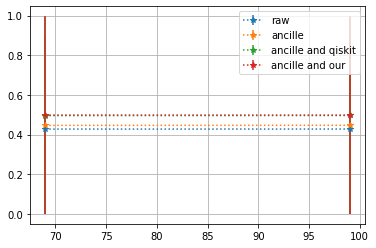

In [39]:
plt.errorbar(steps_range, fids_mean[:,0],fids_dev[:,0],linestyle=':',marker="*",label="raw")

if check!=[]:
    plt.errorbar(steps_range, fids_mean[:,1],fids_dev[:,1],linestyle=':',marker="*",label="ancille")

    if measure_mitigation=="yes":
        plt.errorbar(steps_range, fids_mean[:,2],fids_dev[:,2],linestyle=':',marker="*",label="ancille and qiskit")
        plt.errorbar(steps_range, fids_mean[:,3],fids_dev[:,3],linestyle=':',marker="*",label="ancille and our")
        
plt.legend()
plt.grid()

plt.show()

In [40]:
print(fids)

[[[0.85591666 0.89343759 0.99252606 0.99670714]
  [0.85502599 0.89226679 0.99071253 0.99610703]
  [0.85527525 0.89310162 0.99072017 0.99672289]
  [0.85489113 0.89226163 0.99080629 0.996596  ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]

 [[0.85643614 0.89364894 0.99178199 0.99700197]
  [0.85681922 0.89410036 0.9919505  0.99532768]
  [0.85482763 0.89289056 0.99137135 0.99438493]
  [0.85512702 0.89346607 0.99428634 0.9971583 ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]]


### creo il file con i dati

In [41]:
if check==[0] or check==0:
    c_auss="noc" 
else:
    c_auss="yesc"

dati=("#%d_%d_%d_%.4f_%s_%s \n" %(shots, reps, precision, tempo, c_auss, evo_type))
nome="fid_vs_steps_10-03_01.txt"

#f = open("dati_esame_ruben/" + nome, "w")
f.write(dati)

for i in range(n_s):
    f.write("%d " %(steps_range[i]))
    for j in range(4):
        f.write("%.5f " %(fids_mean[i,j]))
        f.write("%.5f " %(fids_dev[i,j]))
    f.write("\n")

f.close()

NameError: name 'f' is not defined